In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

from sem_context import SemContext
import event_generation
import encoding_schemes
from event_schemas import BasicRNN, HybridRNN
import hrr

import keras

Using TensorFlow backend.


### Helper Functions

In [2]:
# takes in set of events and returns encoded and decoded errors against generating fillers
def evaluate_predictions(encoding, events, fillers, context, testing = False):
    avg_encoded_error = 0.0
    avg_decoded_error = np.zeros(6)
    # traverse all evaluation events
    for e in range(len(events)):
        seen = [events[e][0]]
        encoded_error = 0.0
        decoded_error = np.zeros(6)
        # traverse all scene excluding the first
        for s in range(1, len(events[e])):
            prediction = hrr.normalize(transition_model.predict(seen))
            encoded_error += np.linalg.norm(events[e][s] - prediction)/(len(events[e]) - 1)
            decoded_error += np.asarray(encoding_schemes.filler_errors(encoding, prediction, fillers[e][s], context, testing))/(len(events[e]) - 1)
            seen.append(events[e][s])
        avg_encoded_error += encoded_error
        avg_decoded_error += decoded_error
    return [avg_encoded_error/len(events), avg_decoded_error/len(events)]

In [3]:
# train on set of events split into segments, evaluate after each segment
def train_online(context, encoding, segment_size, num_segments, eval_size, transition_model):
    errors = {}
    decoded_errors = []
    encoded_errors = []
    for segment in range(num_segments):
        # generate evaluation set and calculate evaluation error 
        testing, testing_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = True)
        testing_errors = evaluate_predictions(encoding, testing, testing_fillers, context, testing = True)
        encoded_errors.append(testing_errors[0])
        decoded_errors.append(testing_errors[1])
        # generate training set and train online for each event
        training, training_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = segment_size, testing = False)
        for e in range(len(training)):
            X = np.asarray([training[e][0:len(training[e]) - 1]])
            Y = np.asarray([training[e][1:len(training[e])]])
            #Y = np.asarray([list(map(lambda x: encoding_schemes.fillers_to_baseline(training_fillers[e][x], context), range(1, len(training[e]))))])
            transition_model.model.fit(X, Y, verbose=0)
    errors['decoded_errors'] = np.asarray(decoded_errors)
    errors['encoded_errors'] = np.asarray(encoded_errors)
    return errors

In [4]:
# plot encoded and decoded errors
def plot_errors(encoding, errors):
    num = len(errors['encoded_errors'])
    plt.subplot(2, 1, 1)
    plt.plot(range(num), errors['encoded_errors'])
    plt.title(encoding + " encoded error")
    plt.xlabel("training segment")
    plt.ylabel("average event rmse")
    plt.subplot(2, 1, 2)
    plt.plot(range(num), list(map(lambda x : x, errors['decoded_errors'][:,3])), label = "agent")
    plt.plot(range(num), list(map(lambda x : x, errors['decoded_errors'][:,4])), label = "action")
    plt.plot(range(num), list(map(lambda x : x, errors['decoded_errors'][:,5])), label = "patient")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(encoding + " decoded error")
    plt.xlabel("training segment")
    plt.ylabel("average event filler error")

### Setup

In [5]:
dim = 100
nouns = ['coffeeshop', 'coffee', 'line']
verbs = ['enter', 'obey', 'cut', 'buy', 'confront', 'shove', 'glare', 'ignore', 'yield_to', 'hit', 'apologize', 'leave']
properties = ['thirsty', 'violent', 'impatient', 'intimidating', 'kind']
context = SemContext(dim, nouns, verbs, properties, num_train_actors = 50, num_test_actors = 20)

segment_size = 100
eval_size = 75
num_segments = 101

In [6]:
def plot_decoded(encoding, errors):
    num = len(errors['encoded_errors'])
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,0])), label = "agent")
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,1])), label = "action")
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,2])), label = "patient")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(encoding + " decoded error")
    plt.xlabel("training segment")
    plt.ylabel("average event filler error")
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

### Hybrid RNN

In [7]:
transition_model = HybridRNN(dim)
all_property_addition_errors = train_online(context, 'all_property_addition', segment_size, num_segments, eval_size, transition_model)

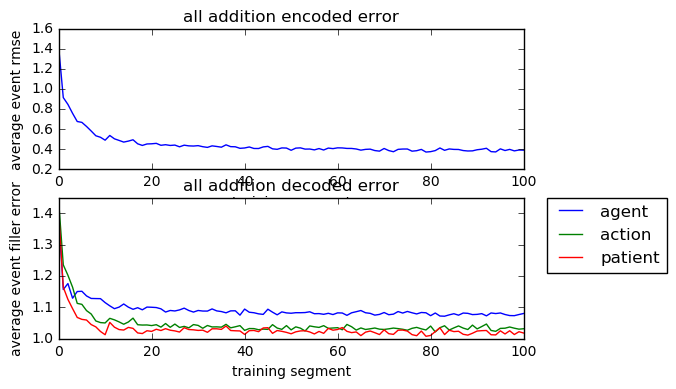

In [8]:
plot_errors("all addition", all_property_addition_errors)

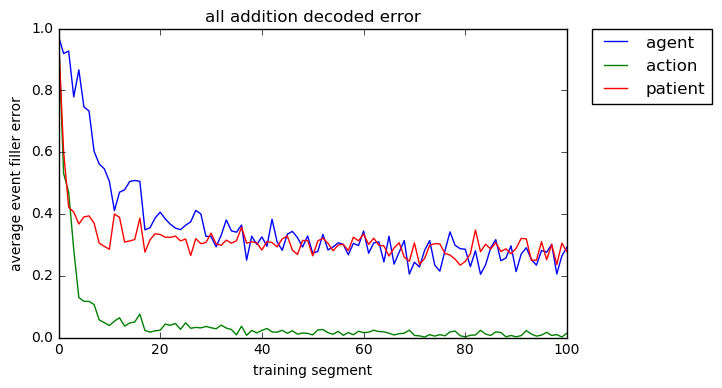

In [9]:
plot_decoded("all addition", all_property_addition_errors)